In [1]:
import pandas as pd
import json
import folium
import time

#Create a function to tranform the data from the combined Scooter data to a usable dataframe
def tranform_scooter_file(original_scooter_file,new_scooter_file):
    #Read the data file from the API pull and change the Zipcode into a String rather than identifying it as a float
    #Modify the Date PollTime from an object type to a UTC date type
    dateCols = ['PollTime']
    file = pd.read_csv(original_scooter_file,low_memory=False, dtype = {'Zipcode':str}, parse_dates=dateCols)
    #Slim down the file to only contain the informaiton that is needed
    data = file[['PollTime','CompanyName','NumberAvailable','Zipcode','Poverty Rate','Poverty Type']]
    #Add new columns with date parts to hours, days and month
    data['Hour']= data.loc[:,'PollTime'].dt.tz_convert('US/Central').dt.hour
    data['Day']= data.loc[:,'PollTime'].dt.tz_convert('US/Central').dt.day
    data['Month']= data.loc[:,'PollTime'].dt.tz_convert('US/Central').dt.month
    #write the file to scr to be used later
    data.to_csv(new_scooter_file)

#Create a function that can run the file when needed
def New_GeoJson(original_json_file, new_json_file):
    #Open the GeoJson file found in Github
    with open(original_json_file,'r') as jsonFile:
        Temp = json.load(jsonFile)
    tmp = Temp

    #Create a new dataset that contains only the the codes in our dataset
    geozips = []
    for i in range(len(tmp['features'])):
        if tmp['features'][i]['properties']['ZCTA5CE10'] in list(data['Zipcode'].unique().astype(str)):
            geozips.append(tmp['features'][i])

    new_json = dict.fromkeys(['type','features'])
    #add new itmes to file
    new_json['type'] = 'FeatureCollection'
    new_json['features'] = geozips

    #Create save the new dataset to a Json file
    open(new_json_file, 'w').write(
        json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
    )

In [2]:
#This cell does not need to be run unless there is a change to the original files that were generated and used
#these functions take some time to run
original_scooter_file = 'scooter_complete_df.csv'
new_scooter_file = 'Scooter_Df_HoursAndDays.csv'
original_json_file = 'mn_minnesota_zip_codes_geo-min.json'
new_json_file = 'updated-file.json'

#Run Tranform function to create transformed file
tranform_scooter_file(original_scooter_file,new_scooter_file)

#Run Tranform function to create new geojson file
New_GeoJson(original_json_file, new_json_file)

C:\Users\mlaska\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


NameError: name 'data' is not defined

In [120]:
#Create a function that takes the newly created data frame and creates columns that can be mapped
Column = 'ComanyName'
df_hours=pd.read_csv('Scooter_df_HrsAndDays.csv', dtype={'Zipcode':str})
df_hours.dropna(how='all')
grouped_df = df_hours[['Day','Zipcode',Column]].groupby(['Zipcode',Column]).describe()
lean_group_df= grouped_df['Day'][['mean']]
#LoopList = lean_group_df.reset_index()['Hour'].unique().tolist()
Graph_Table = lean_group_df.unstack(1)['mean'].reset_index()#.rename(columns = {'2':'Two'})
Graph_Table
#Need to find a way to either change the names of columns using the index, or to reference columns by index in the Choropleth

KeyError: "['ComanyName'] not in index"

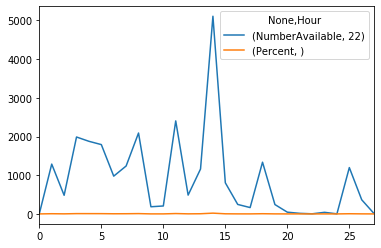

In [38]:
New_data = data[data['Hour']==22]
New_data
a = pd.DataFrame(New_data[['Zipcode','NumberAvailable','Hour']].groupby(['Hour','Zipcode']).count().unstack(0))
a['Percent'] = a['NumberAvailable']/a['NumberAvailable'].sum()*100
a = a.reset_index()
a.plot(kind='line')

In [ ]:
def count_distribution(df,zipcode,headerwithcount):
    group_counts = pd.DataFrame(df.groupby([zipcode,headerwithcount]).size().unstack(1))
    group_counts.reset_index(inplace=True)
    return group_counts
#https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20

In [12]:
gp = me.groupby(['Zipcode'])
PV = pd.DataFrame(gp['Poverty Rate'].mean())
#a['Poverty Rate'] = pd.DataFrame(gp['Poverty Rate'].mean())

PV = PV.reset_index()
count_distribution(me,'Zipcode','CompanyName')
PV = PV.set_index('Zipcode')
#PV.reset_index(inplace =True)
PV = PV.reset_index()


NameError: name 'me' is not defined

In [ ]:
# table = main table/data fram we read from (pandas DataFrame)
# zips = zipcode column name from table (string)
# mapped_Feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map (string)
def create_map(table, zips, mapped_feature):
    #reading of the updated jsonfile
    la_geo = r'updated-file.json'
    #initializing a Folium map with Minneapolis lon and lat
    m = folium.Map(location = [44.9778,-93.2650], zoom_start = 11)
    #creating a choropleth map
    folium.Choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        #refers to which key within the GeoJson to map the Zip code to
        key_on = 'feature.properties.ZCTA5CE10',
        # first element contains location information, second element feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' Across MSP'
    ).add_to(m)
    #folium.LayerControl().add_to(m)
    #save map
    m
    m.save(outfile = mapped_feature + '_map.html')
for i in ['Lyft','Lime','Spin']:
    create_map(count_distribution(data,'Zipcode','CompanyName'),'Zipcode',i)    


In [115]:
#This Map shows the poverty Rates that have been defined.  The darker the color the more impoverished the area. 
m = folium.Map(location = [44.9778,-93.2650], zoom_start = 11)
la_geo = r'updated-file.json'
folium.Choropleth(
    geo_data=la_geo,
    name='choropleth',
    data = Graph_Table,
    columns=[:,:],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='RdYlGn',
#    fill_opacity=0.7,
#    line_opacity=0.2,
#    legend_name='thing'
).add_to(m)
m
#m.save(outfile = 'Scooter_Usage_End_of_day_map.html')
#https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/

SyntaxError: invalid syntax (<ipython-input-115-af577c7ad683>, line 8)

In [ ]:
#Use this code to put together moving and static heatmaps
def generateBaseMap(default_location=[44.9778,-93.2650], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

from folium.plugins import HeatMap
PV = df[df.month>4].copy()
df_copy['count'] = 1
base_map = generateBaseMap()
HeatMap(data=PV[['Zipcode', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
